# SegPC 2021
This [challenge](https://segpc-2021.grand-challenge.org/) was positioned towards robust segmentation of cells which is the first stage to build such a tool for plasma cell cancer, namely, Multiple Myeloma (MM), which is a type of blood cancer. They provided images after stain color normalization.

In this challenge, the target was instance segmentation of cells of interest. For each input image, both nuclei and cytoplasm were required to be segmented separately for each cell of interest.

### Our purpose 
In this work, we used this dataset for a bit different purpose. Here, we want to use the SegPC2021 database to create an independent image centered on the nucleus for each desired cell in this dataset, with the ultimate goal of obtaining the cytoplasm of that cell. Also, the nucleus mask will be used as an auxiliary channel in the input images. You can refer to [this article](https://arxiv.org/abs/2105.06238) for more information. You can download the main dataset using the following links:

- [Official page](https://ieee-dataport.org/open-access/segpc-2021-segmentation-multiple-myeloma-plasma-cells-microscopic-images)
- [Alternative link](https://www.kaggle.com/datasets/sbilab/segpc2021dataset)

In [1]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms, utils
from torchvision.io import read_image
from torchvision.io.image import ImageReadMode
import torch.nn.functional as F

In [46]:
class SegPC2021Dataset(Dataset):
    def __init__(self,
                 mode, # 'tr'-> train, 'vl' -> validation, 'te' -> test
                 input_size=224,
                 scale=2.5,
                 data_dir=None, 
                 dataset_dir=None,
                 one_hot=True,
                 force_rebuild=False,
                 img_transform=None, 
                 msk_transform=None):
        # pre-set variables
        self.data_dir = data_dir if data_dir else "/path/to/datasets/segpc/np"
        self.dataset_dir = dataset_dir if dataset_dir else "/path/to/datasets/segpc/TCIA_SegPC_dataset/"
        self.mode = mode
        # input parameters
        self.img_transform = img_transform
        self.msk_transform = msk_transform
        self.input_size = input_size
        self.scale = scale
        self.one_hot = one_hot
        
        # loading data
        self.load_dataset(force_rebuild=force_rebuild)
    

    def load_dataset(self, force_rebuild):
        INPUT_SIZE = self.input_size
        ADD = self.data_dir
        
#         build_segpc_dataset(
#             input_size = self.input_size,
#             scale = self.scale,
#             data_dir = self.data_dir,
#             dataset_dir = self.dataset_dir,
#             mode = self.mode,
#             force_rebuild = force_rebuild,
#         )
        
        print(f'loading X_{self.mode}...')
        self.X = np.load(f'{ADD}/cyts_{self.mode}_{self.input_size}x{self.input_size}_s{self.scale}_X.npy')
        print(f'loading Y_{self.mode}...')
        self.Y = np.load(f'{ADD}/cyts_{self.mode}_{self.input_size}x{self.input_size}_s{self.scale}_Y.npy')
        print('finished.')


    def __len__(self):
        return len(self.X)


    def __getitem__(self, idx):
        img = self.X[idx]
        msk = self.Y[idx]
        msk = np.where(msk<0.5, 0, 1)

        if self.img_transform:
            img = self.img_transform(img)
            img = (img - img.min())/(img.max() - img.min())
        if self.msk_transform:
            msk = self.msk_transform(msk)
            msk = (msk - msk.min())/(msk.max() - msk.min())
            
        if self.one_hot:
            msk = F.one_hot(torch.squeeze(msk).to(torch.int64))
            msk = torch.moveaxis(msk, -1, 0).to(torch.float)
            
        sample = {'image': img, 'mask': msk, 'id': idx}
        return sample

loading X_tr...
loading Y_tr...
finished.
loading X_vl...
loading Y_vl...
finished.
loading X_te...
loading Y_te...
finished.
Training torch.Size([8, 2, 224, 224])


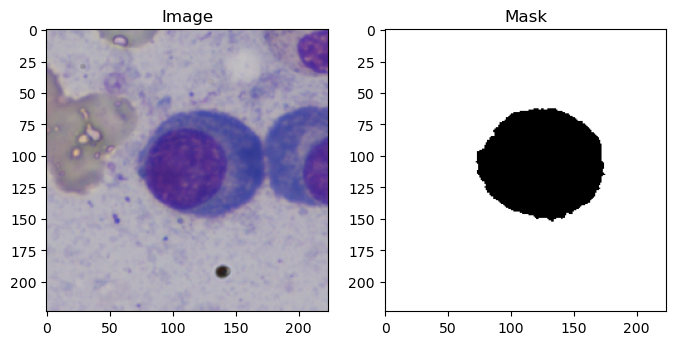

Validation


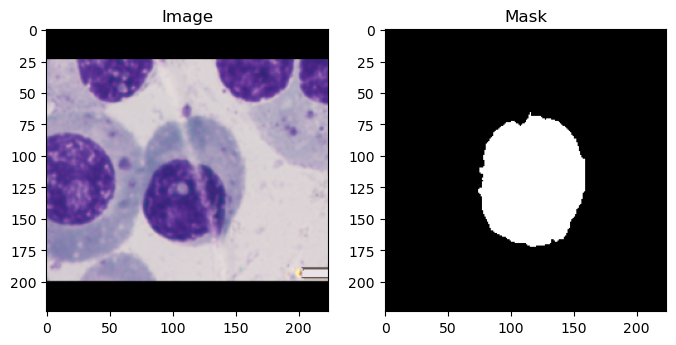

Test


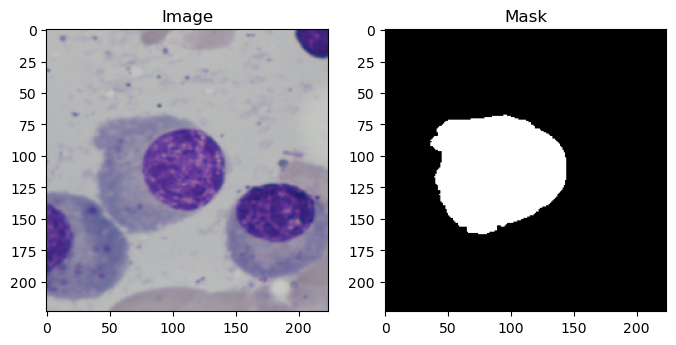

In [47]:
import sys
sys.path.append('..')
from utils import show_sbs
from torch.utils.data import DataLoader, Subset
from torchvision import transforms



# ------------------- params --------------------
INPUT_SIZE = 224
DATA_DIR = "/path/to/datasets/segpc/np"

TR_BATCH_SIZE = 8
TR_DL_SHUFFLE = True
TR_DL_WORKER = 1

VL_BATCH_SIZE = 12
VL_DL_SHUFFLE = False
VL_DL_WORKER = 1

TE_BATCH_SIZE = 12
TE_DL_SHUFFLE = False
TE_DL_WORKER = 1
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


# ----------------- transform ------------------
# transform for image
img_transform = transforms.Compose([
    transforms.ToTensor()
])
# transform for mask
msk_transform = transforms.Compose([
    transforms.ToTensor()
])
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


# ----------------- dataset --------------------
# preparing training dataset
# preparing training dataset
tr_dataset = SegPC2021Dataset(
    mode="tr",
    input_size=INPUT_SIZE,
    force_rebuild=False,
    img_transform=img_transform,
    msk_transform=msk_transform
)
# preparing training dataset
vl_dataset = SegPC2021Dataset(
    mode="vl",
    input_size=INPUT_SIZE,
    force_rebuild=False,
    img_transform=img_transform,
    msk_transform=msk_transform
)
# preparing training dataset
te_dataset = SegPC2021Dataset(
    mode="te",
    input_size=INPUT_SIZE,
    force_rebuild=False,
    img_transform=img_transform,
    msk_transform=msk_transform
)

# prepare train dataloader
tr_loader = DataLoader(
    tr_dataset, 
    batch_size=TR_BATCH_SIZE, 
    shuffle=TR_DL_SHUFFLE, 
    num_workers=TR_DL_WORKER,
    pin_memory=True
)

# prepare validation dataloader
vl_loader = DataLoader(
    vl_dataset, 
    batch_size=VL_BATCH_SIZE, 
    shuffle=VL_DL_SHUFFLE, 
    num_workers=VL_DL_WORKER,
    pin_memory=True
)

# prepare test dataloader
te_loader = DataLoader(
    te_dataset, 
    batch_size=TE_BATCH_SIZE, 
    shuffle=TE_DL_SHUFFLE, 
    num_workers=TE_DL_WORKER,
    pin_memory=True
)

# -------------- test -----------------
# test and visualize the input data
for batch in tr_loader:
    img = batch['image']
    msk = batch['mask']
    print("Training", msk.shape)
    show_sbs(img[0,:-1,:,:], msk[0,0])
    break
    
for batch in vl_loader:
    img = batch['image']
    msk = batch['mask']
    print("Validation")
    show_sbs(img[0,:-1,:,:], msk[0,1])
    break
    
for batch in te_loader:
    img = batch['image']
    msk = batch['mask']
    print("Test")
    show_sbs(img[0,:-1,:,:], msk[0,1])
    break

## Check for .py

In [ ]:
import sys
sys.path.append('.')
from segpc import (
    SegPC2021TrainingDataset,
    SegPC2021ValidationDataset,
    SegPC2021TestDataset
)

In [1]:
import sys
sys.path.append('..')
from utils import show_sbs
from torch.utils.data import DataLoader, Subset
from torchvision import transforms


# ------------------- params --------------------
INPUT_SIZE = 256

TR_BATCH_SIZE = 8
TR_DL_SHUFFLE = True
TR_DL_WORKER = 1

VL_BATCH_SIZE = 12
VL_DL_SHUFFLE = False
VL_DL_WORKER = 1

TE_BATCH_SIZE = 12
TE_DL_SHUFFLE = False
TE_DL_WORKER = 1
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


# ----------------- transform ------------------
# transform for image
img_transform = transforms.Compose([
    transforms.ToTensor()
])
# transform for mask
msk_transform = transforms.Compose([
    transforms.ToTensor()
])
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


# ----------------- dataset --------------------
# preparing training dataset
tr_dataset = SegPC2021TrainingDataset(
    img_transform=img_transform,
    msk_transform=msk_transform
)
# preparing training dataset
vl_dataset = SegPC2021ValidationDataset(
    img_transform=img_transform,
    msk_transform=msk_transform
)
# preparing training dataset
te_dataset = SegPC2021TestDataset(
    img_transform=img_transform,
    msk_transform=msk_transform
)

# prepare train dataloader
tr_loader = DataLoader(
    tr_dataset, 
    batch_size=TR_BATCH_SIZE, 
    shuffle=TR_DL_SHUFFLE, 
    num_workers=TR_DL_WORKER,
    pin_memory=True
)

# prepare validation dataloader
vl_loader = DataLoader(
    vl_dataset, 
    batch_size=VL_BATCH_SIZE, 
    shuffle=VL_DL_SHUFFLE, 
    num_workers=VL_DL_WORKER,
    pin_memory=True
)

# prepare test dataloader
te_loader = DataLoader(
    te_dataset, 
    batch_size=TE_BATCH_SIZE, 
    shuffle=TE_DL_SHUFFLE, 
    num_workers=TE_DL_WORKER,
    pin_memory=True
)

# -------------- test -----------------
# test and visualize the input data
for batch in tr_loader:
    img = batch['image']
    msk = batch['mask']
    print("Training")
    show_sbs(img[0,:-1,:,:], msk[0])
    break
    
for batch in vl_loader:
    img = batch['image']
    msk = batch['mask']
    print("Validation")
    show_sbs(img[0,:-1,:,:], msk[0])
    break
    
for batch in te_loader:
    img = batch['image']
    msk = batch['mask']
    print("Test")
    show_sbs(img[0,:-1,:,:], msk[0])
    break